In [138]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm
import random

# Test용으로 이미지 1개에 대하여 전처리, 특징추출 과정

## 1. Preprocessing

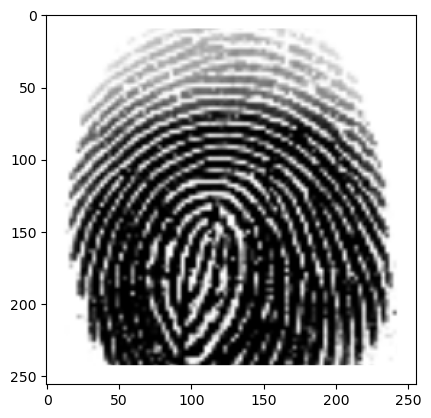

In [4]:
train_path = 'data/train_ref/1.BMP'
img = cv2.imread(train_path)
plt.imshow(img)

# 이미지를 그레이스케일로 변환
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 1-1. Normalization

In [6]:
# 개별 픽셀의 정규화된 그레이 레벨을 계산하는 함수
def normalizePixel(val, m, v, m0, v0):
    """
    val = 픽셀 값
    m = 이미지 전체의 평균값
    v = 이미지 전체의 분산
    m0 = 원하는 평균값
    v0 = 원하는 분산
    """
    x = np.sqrt((v0 * ((val - m) ** 2)) / v)
    if val < m:
        return m0 - x

    return m0 + x

# 이미지 정규화를 수행하는 함수
def normalize(img, m0, v0):
    m = np.mean(img)  # 이미지의 평균값 계산
    v = np.std(img) ** 2  # 이미지의 분산 계산 (표준편차의 제곱)
    (w, h) = img.shape  # 이미지의 너비와 높이
    normalizedImg = img.copy()  # 원본 이미지를 복사하여 정규화된 이미지를 저장할 공간 확보
    for i in range(w):  # 이미지의 각 픽셀에 대해
        for j in range(h):
            normalizedImg[i, j] = normalizePixel(img[i, j], m, v, m0, v0)  # 정규화된 값으로 대체

    return normalizedImg  # 정규화된 이미지 반환


In [7]:
# 이미지를 그레이스케일로 변환
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 원하는 평균과 분산 설정
desired_mean = 100  # 원하는 평균값 예시
desired_variance = 100  # 원하는 분산값 예시

# 이미지 정규화
normalized_img = normalize(gray_img, desired_mean, desired_variance)

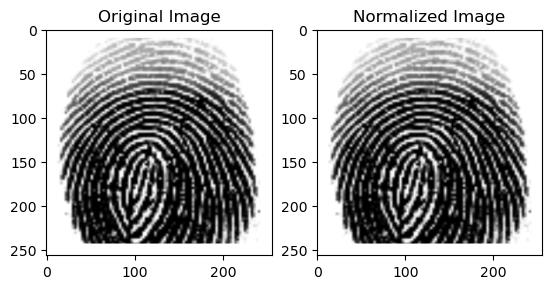

In [8]:
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Normalized Image')
plt.imshow(normalized_img, cmap='gray')
plt.show()

### 1-2. mean filtering

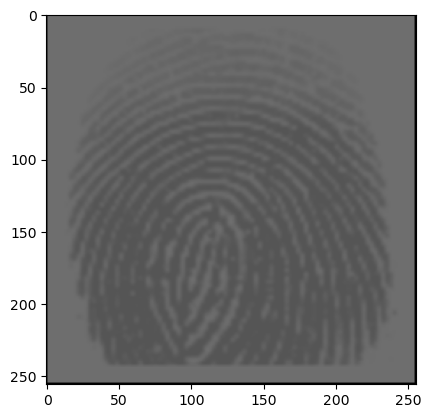

In [10]:
def mean_filtering(image, kernel_size=3):
    # 커널 크기 설정 및 커널 생성
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    # 이미지의 행과 열 크기 얻기
    rows, cols = image.shape[:2]
    # 필터링된 이미지를 저장할 빈 이미지 생성
    filtered_image = np.zeros(image.shape, dtype=np.uint8)
    
    # 이미지 필터링 수행
    for i in tqdm(range(1, rows-1), disable=True):
        for j in range(1, cols-1):
            result = 0
            for k_i in range(0, len(kernel)):
                for k_j in range(0, len(kernel[0])):
                    # 합성곱 연산 수행
                    result += image[i-kernel_size//2+k_i, j-kernel_size//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]
            filtered_image[i, j] = int(result)
    
    return filtered_image
    
img_filtered = mean_filtering(normalized_img)

# 히스토그램 평활화 적용
equalized_img = cv2.equalizeHist(img_filtered)

# 필터링된 이미지 시각화
plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))
plt.show()

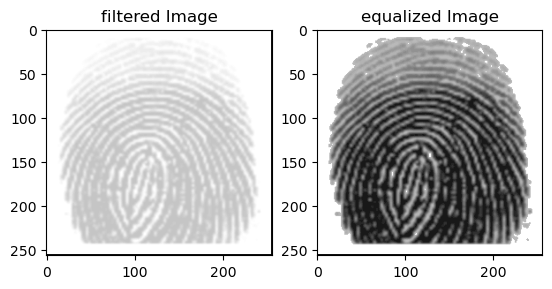

In [11]:
plt.subplot(1, 2, 1)
plt.title('filtered Image')
plt.imshow(img_filtered, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('equalized Image')
plt.imshow(equalized_img, cmap='gray')
plt.show()

### 1-3. 이진화(Binarization)

In [13]:
def binarization(image, kernel_size=11, threshold=2):
    # Adaptive Thresholding 적용
    binary_img = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size, threshold)
    # 모폴로지 연산을 위한 구조화 요소 생성
    kernel = np.ones((2, 2), np.uint8)
    # 침식과 팽창을 순차적으로 적용하여 세션을 부각시킴
    erosion_img = cv2.erode(binary_img, kernel, iterations=2)
    dilation_img = cv2.dilate(erosion_img, kernel, iterations=2)

    return binary_img,erosion_img,dilation_img

binary_img,erosion_img,dilation_img = binarization(equalized_img)

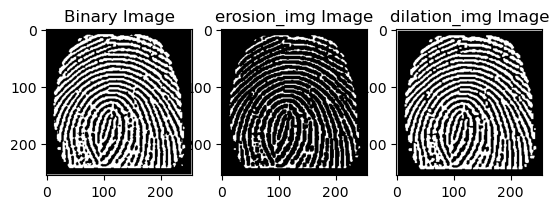

In [14]:
plt.subplot(1, 3, 1)
plt.title('Binary Image')
plt.imshow(binary_img, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('erosion_img Image')
plt.imshow(erosion_img, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('dilation_img Image')
plt.imshow(dilation_img, cmap='gray')
plt.show()

### 1-4. 세선화 
3번이 제일 깔끔함

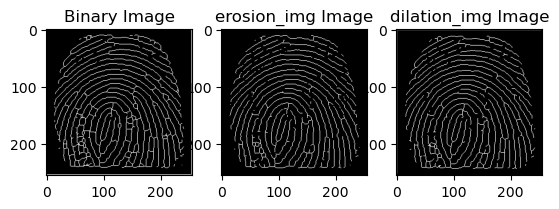

In [16]:
from skimage.morphology import skeletonize

# 이미지 스켈레톤화
skeleton_img1 = skeletonize(binary_img)
skeleton_img2 = skeletonize(erosion_img)
skeleton_img3 = skeletonize(dilation_img)

# 결과 이미지 시각화
plt.subplot(1, 3, 1)
plt.title('Binary Image')
plt.imshow(skeleton_img1, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('erosion_img Image')
plt.imshow(skeleton_img2, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('dilation_img Image')
plt.imshow(skeleton_img3, cmap='gray')
plt.show()

## 2. 특징 추출

### 2-1. End Points, Bifurcation Points 찾기

In [19]:
def find_minutiae(skeleton_img):
    # 결과를 저장할 리스트
    end_points = []
    bifurcation_points = []
    
    # 이미지의 높이와 너비
    height, width = skeleton_img.shape
    
    # 각 픽셀 주변에 3x3 윈도우를 이동하면서 윤곽선 픽셀 개수를 계산
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            #print(skeleton_img[y, x])
            if skeleton_img[y, x] == 1:  # 흰색 픽셀인 경우
                # 3x3 윈도우 내의 흰색 픽셀 개수 세기
                window = skeleton_img[y-1:y+2, x-1:x+2]
                white_pixels = np.sum(window == 1)
                
                # 3x3 윈도우의 중앙 픽셀이 분기점 또는 끝점인지 판별
                if white_pixels == 2:
                    # 끝점인 경우
                    end_points.append((x, y))
                elif white_pixels == 4:
                    # 분기점인 경우
                    bifurcation_points.append((x, y))
    
    return end_points, bifurcation_points

# skeleton_img3에서 Minutiae 검출
end_points, bifurcation_points = find_minutiae(skeleton_img3)
print("End Points:", end_points)
print("Bifurcation Points:", bifurcation_points)


End Points: [(159, 12), (68, 16), (62, 18), (116, 18), (112, 19), (100, 20), (58, 21), (186, 28), (75, 31), (121, 31), (70, 32), (113, 32), (164, 32), (192, 32), (203, 32), (111, 33), (171, 35), (105, 36), (79, 37), (74, 39), (45, 40), (56, 40), (113, 40), (184, 40), (53, 42), (91, 42), (189, 42), (84, 44), (195, 45), (187, 46), (57, 48), (181, 48), (215, 48), (201, 49), (160, 50), (53, 51), (68, 52), (163, 52), (189, 52), (64, 53), (59, 58), (90, 58), (96, 58), (54, 61), (220, 61), (214, 65), (71, 68), (218, 68), (68, 70), (65, 72), (39, 73), (61, 74), (37, 76), (27, 78), (168, 83), (212, 84), (38, 85), (82, 92), (78, 93), (229, 93), (23, 96), (203, 99), (203, 104), (113, 106), (109, 110), (142, 110), (156, 110), (54, 111), (147, 112), (161, 112), (18, 115), (48, 116), (211, 116), (216, 118), (54, 119), (154, 119), (236, 119), (162, 123), (50, 126), (18, 128), (158, 128), (17, 132), (16, 134), (237, 134), (63, 136), (163, 140), (58, 143), (58, 144), (55, 148), (142, 148), (66, 152), (

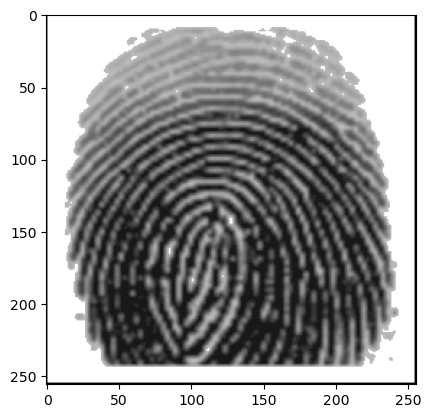

[[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 ...
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 [  0   0   0 ...   0   0   0]]


In [20]:
plt.imshow(equalized_img, cmap='gray')
plt.show()
print(equalized_img)

### 2-2. 경계값 제거

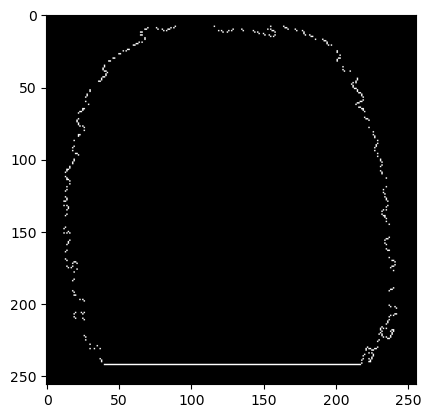

In [22]:
def find_fingerprint_contour(binary_image):
    # 컨투어 찾기
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 컨투어 중 최대 영역 찾기
    max_contour = max(contours, key=cv2.contourArea)
    
    # 최대 영역의 외곽선 좌표 반환
    return max_contour

def get_fingerprint_outline(contour):
    # 외곽선 좌표를 x, y로 분리
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    
    return x, y

def add_bottom_coordinates(x, y):
    # y값이 가장 큰 좌표들 찾기
    max_y = np.max(y)
    bottom_indices = np.where(y == max_y)[0]
    
    # x값이 차이나는 좌표들 찾기
    x_bottom = x[bottom_indices]
    y_bottom = y[bottom_indices]
    
    # x값이 차이가 나는 부분을 채우기 위한 새로운 좌표들 추가
    new_x = []
    new_y = []
    
    for i in range(len(x_bottom) - 1):
        new_x.append(x_bottom[i])
        new_y.append(y_bottom[i])
        if x_bottom[i+1] - x_bottom[i] > 1:
            for j in range(x_bottom[i] + 1, x_bottom[i+1]):
                new_x.append(j)
                new_y.append(max_y)
                
    new_x.append(x_bottom[-1])
    new_y.append(y_bottom[-1])
    
    return np.array(new_x), np.array(new_y)

def find_full_fingerprint_outline(equalized_img):
    # 내부 영역 선택
    inner_region = equalized_img[1:-1, 1:-1]
    # 지문 영역 분리
    fingerprint_region = inner_region < 255
    # 경계 추출
    fingerprint_contour = find_fingerprint_contour(fingerprint_region.astype(np.uint8))
    # 테두리 좌표 얻기
    fingerprint_outline_x, fingerprint_outline_y = get_fingerprint_outline(fingerprint_contour)
    # 바닥 좌표 추가
    bottom_x, bottom_y = add_bottom_coordinates(fingerprint_outline_x, fingerprint_outline_y)
    # 바닥 좌표를 기존 외곽선 좌표에 추가
    full_outline_x = np.concatenate((fingerprint_outline_x, bottom_x))
    full_outline_y = np.concatenate((fingerprint_outline_y, bottom_y))
    
    return full_outline_x, full_outline_y

full_outline_x, full_outline_y = find_full_fingerprint_outline(equalized_img)

# 빈 배경 이미지 생성
empty_background = np.zeros_like(equalized_img)

# 각 좌표에 점 그리기
for x, y in zip(full_outline_x, full_outline_y):
    empty_background[y, x] = 255  # 흰색 점

# 결과 시각화
plt.imshow(empty_background, cmap='gray')
plt.show()


In [23]:
def remove_points_from_list(points_list, remove_points):
    # 새로운 리스트 생성
    new_points_list = points_list.copy()
    
    # 제거할 좌표가 있는지 확인하고 제거
    for point in remove_points:
        x, y = point
        # 주어진 좌표 주변에 5x5 윈도우를 사용하여 검사
        for i in range(x-2, x+3):
            for j in range(y-2, y+3):
                if (i, j) in new_points_list:
                    new_points_list.remove((i, j))
    
    return new_points_list

# end_points와 bifurcation_points에서 fingerprint_outline_x와 fingerprint_outline_y에 해당하는 좌표 제거
end_points_remove = remove_points_from_list(end_points, list(zip(full_outline_x, full_outline_y)))
bifurcation_points_remove = remove_points_from_list(bifurcation_points, list(zip(full_outline_x, full_outline_y)))

# 결과 출력
print("End Points:", len(end_points))
print("Bifurcation Points:", len(bifurcation_points))
print("Updated End Points:", len(end_points_remove))
print("Updated Bifurcation Points:", len(bifurcation_points_remove))


End Points: 148
Bifurcation Points: 240
Updated End Points: 106
Updated Bifurcation Points: 200


### 2-3. bif, end 점 표시하기

In [266]:
def binary_to_bgr(skeleton_img):
    binary_img = skeleton_img.copy()
    # 이진 이미지의 높이와 너비
    height, width = binary_img.shape
    # 이진 이미지를 3채널 BGR 이미지로 변환
    bgr_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 흰색 픽셀을 (255, 255, 255)로 설정
    bgr_img[np.where(binary_img == True)] = [255, 255, 255]
    
    return bgr_img

In [294]:
def mark_minutiae(skeleton_img, end_points, bifurcation_points):
    # 스켈레톤 이미지를 복사하여 결과 이미지 생성
    marked_img = binary_to_bgr(skeleton_img)
    
    # 끝점을 파란색으로 표시
    for x, y in end_points:
        cv2.circle(marked_img, (x, y), 1, (255, 0, 0), -1)  # 파란색 테두리의 1픽셀 점 표시
    
    # 분기점을 빨간색으로 표시
    for x, y in bifurcation_points:
        cv2.circle(marked_img, (x, y), 1, (0, 0, 255), -1)  # 빨간색 테두리의 1픽셀 점 표시
    #plt.imshow(marked_img)
    return marked_img

# 스켈레톤 이미지에 분기점과 끝점 표시
marked_img = mark_minutiae(skeleton_img3, end_points_remove, bifurcation_points_remove)

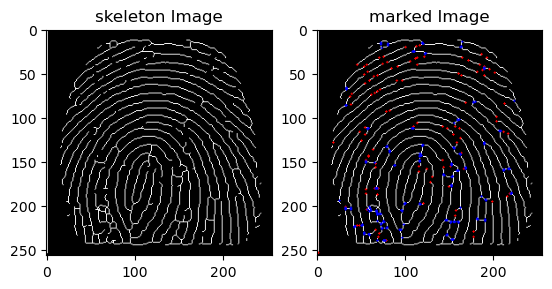

In [270]:
# 결과 이미지 시각화
plt.subplot(1, 2, 1)
plt.title('skeleton Image')
plt.imshow(skeleton_img3, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('marked Image')
plt.imshow(marked_img)
plt.show()

# 전체 train set train & test

In [300]:
def get_fp_feature(img, flg_show=True):
    # 이미지를 그레이스케일로 변환
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 입력 이미지 정규화 및 평균 필터링 수행
    normalized_img = normalize(gray_img, 100, 100)
    img_filtered = mean_filtering(normalized_img)

    # 히스토그램 평활화 적용
    equalized_img = cv2.equalizeHist(img_filtered)

    # 이진화 수행
    binary_img,erosion_img,dilation_img = binarization(equalized_img)

    # 스켈레톤 이미지 생성
    skeleton_img = skeletonize(dilation_img)

    # 끝점과 분기점 추출
    end_points, bifurcation_points = find_minutiae(skeleton_img)
    full_outline_x, full_outline_y = find_full_fingerprint_outline(equalized_img)
    # end_points와 bifurcation_points에서 fingerprint_outline_x와 fingerprint_outline_y에 해당하는 좌표 제거
    end_points_remove = remove_points_from_list(end_points, list(zip(full_outline_x, full_outline_y)))
    bifurcation_points_remove = remove_points_from_list(bifurcation_points, list(zip(full_outline_x, full_outline_y)))
    

    # 결과 시각화
    if flg_show:
        plt.figure(figsize=(15, 10))
        # 원본 사진 출력
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        # 필터링 적용 후 사진 출력
        plt.subplot(2, 3, 2)
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered Image')

        # 노말라이즈 적용 후 사진 출력
        plt.subplot(2, 3, 3)
        plt.imshow(equalized_img, cmap='gray')
        plt.title('Equalized Image')

        # 이진화 사진 출력
        plt.subplot(2, 3, 4)
        plt.imshow(dilation_img, cmap='gray')
        plt.title('Binarized Image')

        # 스켈레톤 사진 출력
        plt.subplot(2, 3, 5)
        plt.imshow(skeleton_img, cmap='gray')
        plt.title('Skeleton Image')

        # 스켈레톤에 점 찍은 사진 출력
        marked_img = mark_minutiae(skeleton_img, end_points_remove, bifurcation_points_remove)
        plt.subplot(2, 3, 6)
        plt.imshow(marked_img)
        plt.title('Minutiae Marked Image')

        plt.show()


    return end_points_remove, bifurcation_points_remove


In [280]:
train_path = 'data/train_ref'
test2_path = 'data/test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test))

477 1428


data/test2/100_type1.BMP
data/test2/100_type1.BMP 100 data/train_ref/100.BMP


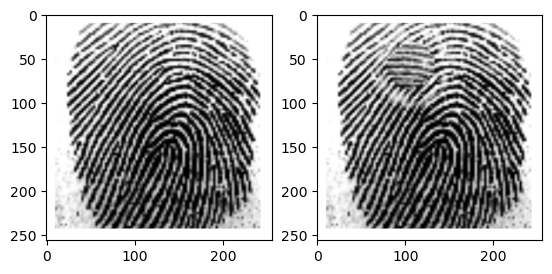

In [282]:
target_path = list_test[0]
print(target_path)
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path)
img_test = cv2.imread(target_path)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')

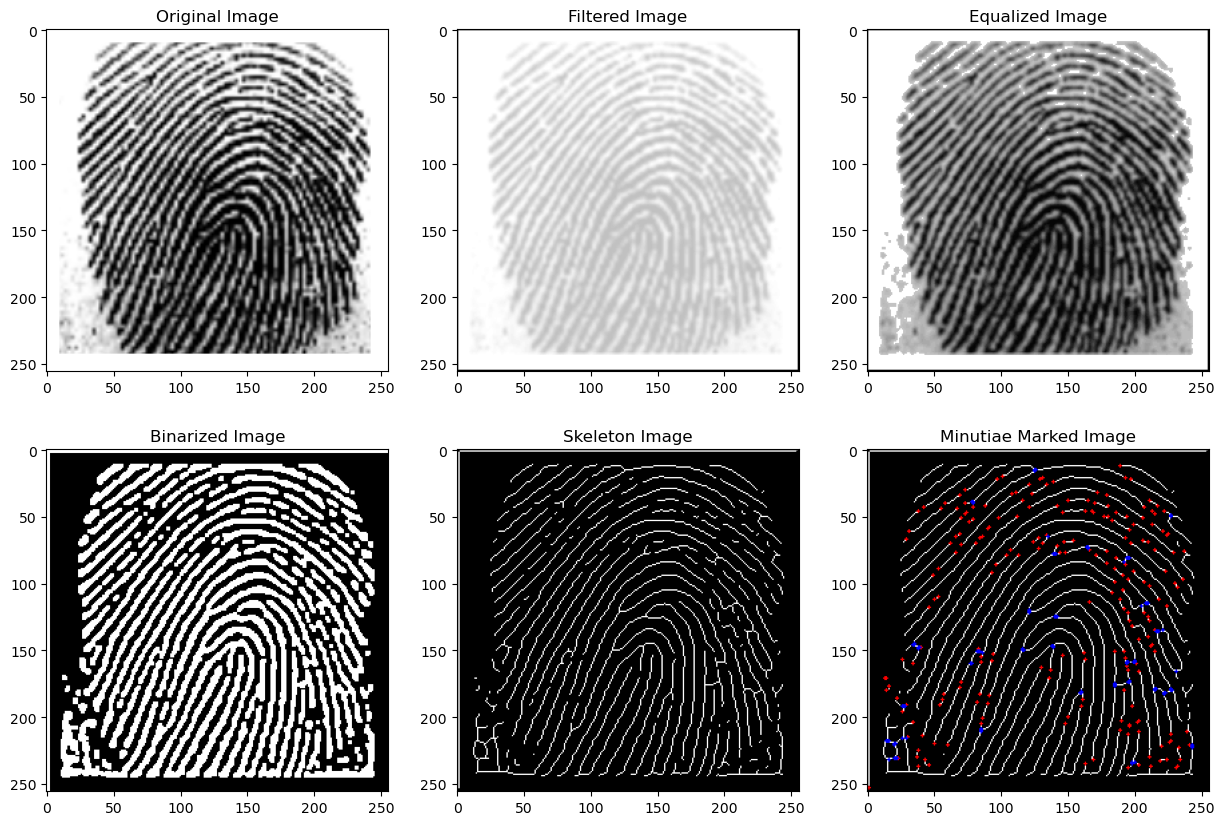

In [302]:
feat_end, feat_bif = get_fp_feature(img_train, flg_show=True)

## 3. 매칭 - L2 norm 이용

### 3-1. train, test 데이터셋 전처리, 특징추출 수행

In [35]:
def preprocess_images(list_images):
    features = {}
    for image_path in tqdm(list_images):
        basename = os.path.basename(image_path)
        img = cv2.imread(image_path)
        db_x_end, db_x_bif = get_fp_feature(img, flg_show=False)
        features[basename] = (db_x_end, db_x_bif)
    return features

In [36]:
train_features = preprocess_images(list_train)

  0%|          | 0/477 [00:00<?, ?it/s]

In [164]:
test_features = preprocess_images(list_test)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [194]:
feat_end, feat_bif = get_fp_feature(img_test, flg_show=False)
feat_test = np.concatenate([feat_end, feat_bif], axis=0)

### 3-2. test data에 대하여 train data와의 distance 계산

In [233]:
def calculate_distances(test_feature, train_features):
    distances = {}
    matches = {}
    matched_points = {}
    query_points = []
    train_points = []
    result_image_name = ''

    min_mean_dist = float('inf')
    min_matched_test_points = None
    min_matched_train_points = None

    for image_name, (db_x_end, db_x_bif) in train_features.items():
        feat_db = np.concatenate([db_x_end, db_x_bif], axis=0)
        if len(feat_db) == 0 or len(test_feature) == 0:
            continue

        # 거리 계산
        dists = np.linalg.norm(feat_db[:, np.newaxis, :] - test_feature[np.newaxis, :, :], axis=2)

        # 매칭되는 점의 개수 및 좌표 계산
        match_indices = np.where(np.min(dists, axis=0) < 1)[0]  # 임계값 1 이하인 점의 인덱스
        if len(match_indices) == 0:
            continue

        match_count = len(match_indices)
        matches[image_name] = match_count

        # 최소 거리의 평균 계산
        mean_dist = np.mean(np.min(dists, axis=0))
        distances[image_name] = mean_dist
        

        # 매칭된 점의 좌표 저장
        matched_test_points = test_feature[match_indices]
        matched_train_points = feat_db[np.argmin(dists[:, match_indices], axis=0)]
        

        # 현재 이미지의 평균 거리가 최소값보다 작으면 갱신
        if match_count > 30 and mean_dist < min_mean_dist:
            
            result_image_name = image_name
            min_mean_dist = mean_dist
            min_matched_test_points = matched_test_points
            min_matched_train_points = matched_train_points

    # 전체 매칭된 점 중에서 거리, 매칭 포인트 개수 조건 만족한 테스트 세트의 매칭 좌표 저장
    matched_points['test'] = min_matched_test_points
    matched_points['train'] = min_matched_train_points

    # query_points, train_points 업데이트
    query_points.extend(min_matched_test_points)
    train_points.extend(min_matched_train_points)

    # 매칭된 점의 인덱스 생성
    matched_indices = list(zip(range(len(query_points)), range(len(train_points))))

    return distances, matches, matched_points, query_points, train_points, matched_indices, result_image_name


def visualize_matches(img_query, img_train, query_points, train_points, matches):
    """
    두 이미지의 매칭된 점을 시각화합니다.

    Args:
    img_query: 비교할 이미지
    img_train: 데이터베이스에 저장된 이미지
    query_points: 비교할 이미지의 특징점들
    train_points: 데이터베이스 이미지의 특징점들
    matches: 매칭된 특징점 쌍들
    """
    result_img = np.hstack((img_query, img_train))
    query_offset = 0
    train_offset = img_query.shape[1]
    
    for (q_index, t_index) in matches:
        q_point = query_points[q_index]
        t_point = train_points[t_index]

        # 랜덤한 RGB 색상 생성
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        
        # 매칭된 점과 점 사이에 선 그리기
        cv2.circle(result_img, (int(q_point[0]) + query_offset, int(q_point[1])), 2, color, 1)
        cv2.circle(result_img, (int(t_point[0]) + train_offset, int(t_point[1])), 2, color, 1)
        cv2.line(result_img, (int(q_point[0]) + query_offset, int(q_point[1])), (int(t_point[0]) + train_offset, int(t_point[1])), color, 1)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Feature Matching')
    plt.axis('off')
    plt.show()


### 3-3. 한 개의 test img로 결과 출력 & 시각화

In [235]:
import time
# 거리 계산 시간 측정
start_time = time.time()
# 데이터 계산
distances, matches, matched_points, query_points, train_points, matched_indices, result_image_name = calculate_distances(feat_test, train_features)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken to calculate distances: {elapsed_time:.2f} seconds")

Time taken to calculate distances: 1.31 seconds


In [222]:
print(f"{target_path} -- Closest image to the test image is: {result_image_name} with distance {distances[result_image_name]} and matches {matches[result_image_name]}")

data/test2/100_type1.BMP -- Closest image to the test image is: 100.BMP with distance 2.1009411717839073 and matches 184


In [224]:
# 모든 distances와 매칭 개수 출력
for image_name in distances.keys():
    print(f"Image: {image_name}, Distance: {distances[image_name]}, Matches: {matches[image_name]}")


Image: 1.BMP, Distance: 12.749747463971163, Matches: 5
Image: 10.BMP, Distance: 5.79109872316817, Matches: 8
Image: 100.BMP, Distance: 2.1009411717839073, Matches: 184
Image: 101.BMP, Distance: 11.786649125519693, Matches: 2
Image: 102.BMP, Distance: 6.7203661888576685, Matches: 7
Image: 104.BMP, Distance: 7.121520378837962, Matches: 3
Image: 105.BMP, Distance: 7.332174561352282, Matches: 2
Image: 106.BMP, Distance: 9.677174591420966, Matches: 6
Image: 107.BMP, Distance: 10.622339902121594, Matches: 3
Image: 108.BMP, Distance: 9.061475759967422, Matches: 4
Image: 11.BMP, Distance: 13.012941920351361, Matches: 4
Image: 111.BMP, Distance: 8.321993470336297, Matches: 5
Image: 112.BMP, Distance: 5.55395677304653, Matches: 9
Image: 113.BMP, Distance: 5.871831973854821, Matches: 3
Image: 116.BMP, Distance: 8.682415405065793, Matches: 2
Image: 12.BMP, Distance: 13.111066038920203, Matches: 2
Image: 120.BMP, Distance: 7.297238455762586, Matches: 8
Image: 122.BMP, Distance: 6.88678172506759, Ma

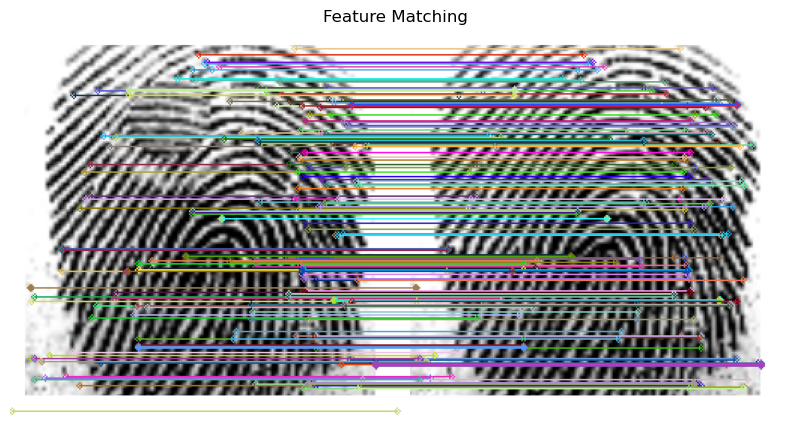

In [226]:
# 매칭된 점 시각화
visualize_matches(img_test, img_train_closest, query_points, train_points, matched_indices)

### 3-4. 전체 test dataset 매칭 수행

In [237]:
# 결과를 저장할 리스트 초기화
result = []

# 각 이미지에 대해 반복문 실행
for test_image_name, (q_x_end, q_x_bif) in tqdm(test_features.items(), desc="Processing images"):
    feat_q = np.concatenate([q_x_end, q_x_bif], axis=0)
    # 데이터 계산
    distances, matches, _, _, _, _, result_image_name = calculate_distances(feat_q, train_features)
    
    distance = distances[result_image_name]
    num_matches = matches[result_image_name]
    
    # 결과를 리스트에 저장
    result.append((test_image_name, result_image_name, distance, num_matches))

    # 결과 출력
    print(f"{test_image_name} -- Closest image to the test image is: {result_image_name} with distance {distance} and matches {num_matches}")

Processing images:   0%|          | 0/1428 [00:00<?, ?it/s]

100_type1.BMP -- Closest image to the test image is: 100.BMP with distance 2.1009411717839073 and matches 184
100_type2.BMP -- Closest image to the test image is: 100.BMP with distance 2.7128571745942653 and matches 184
100_type3.BMP -- Closest image to the test image is: 100.BMP with distance 0.8337364118328362 and matches 271
101_type1.BMP -- Closest image to the test image is: 101.BMP with distance 4.547920492518944 and matches 118
101_type2.BMP -- Closest image to the test image is: 101.BMP with distance 3.9542319319841575 and matches 132
101_type3.BMP -- Closest image to the test image is: 101.BMP with distance 2.151567023987018 and matches 229
102_type1.BMP -- Closest image to the test image is: 102.BMP with distance 1.3822887681625948 and matches 311
102_type2.BMP -- Closest image to the test image is: 102.BMP with distance 2.488865999786975 and matches 210
102_type3.BMP -- Closest image to the test image is: 102.BMP with distance 0.5831197008387751 and matches 434
104_type1.BMP

## 4. Metric 계산 ­Precision, Recall, FAR, FRR, ACC

In [317]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [321]:
# 실제 라벨과 예측 라벨 리스트 생성
true_labels = [test_image_name.split('_')[0] for test_image_name, _, _, _ in result]
predicted_labels = [result_image_name.split('.')[0] for _, result_image_name, _, _ in result]

# Precision, Recall, Accuracy 계산
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)

# Confusion matrix를 사용하여 FAR, FRR 계산
conf_matrix = confusion_matrix(true_labels, predicted_labels)
false_acceptance = np.sum(np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))
false_rejection = np.sum(np.sum(conf_matrix, axis=1) - np.diag(conf_matrix))
total_negatives = np.sum(conf_matrix) - np.sum(np.diag(conf_matrix))
total_positives = np.sum(np.diag(conf_matrix))

far = false_acceptance / total_negatives if total_negatives > 0 else 0
frr = false_rejection / total_positives if total_positives > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"FAR (False Acceptance Rate): {far}")
print(f"FRR (False Rejection Rate): {frr}")

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
FAR (False Acceptance Rate): 0
FRR (False Rejection Rate): 0.0
